# Pete's Princeton Python Plots

In [46]:
"""
Import needed libraries
"""

# Import general modules

import numpy as np
import pandas as pd
import copy
import sys
import cf
import itertools
import os.path
from netCDF4 import Dataset

# Import analysis modules

from scipy.stats import ttest_ind_from_stats

# Import plotting modules

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.colors import LogNorm

# Import dedicated functions for this project

from Functions import *

In [14]:
%load_ext autoreload
%autoreload 2

# Our data

We will be looking at data from 3 different experiments: A pre-industrial control (piControl or ctl), A high-CO2 experiment (abrupt4xCO2 or CO2), and a high-CO2 experiment with solar geoengineering (G1 or Geo100).

In [32]:
exp_list = ['ctl', 'CO2', 'Geo100']
exp_filename = {'ctl':'piControl','CO2':'abrupt4xCO2','Geo100':'G1'}

We will be looking at 5 different variables:
- 2m surface air temperature (tas)
- The annual maximum of the daily max surface air temperature (txx)
- Precipitation (pr)
- The annual maximum of consecutive 5-day precipitation (rx5day)
- Precipitation minus evaporation (p-e)

In [27]:
var_list = ['tas', 'txx', 'pr', 'rx5day', 'p-e']
# the name of the variable in filenames:
var_filename = {'tas':'tas_Amon', 'txx':'txxETCCDI_yr', 'pr':'pr_Amon', 'rx5day':'rx5dayETCCDI_yr', 'p-e':'p-e_Amon'}
# long name of the variable for plots
var_longname = {'tas':'2m Temperature','txx':'Max 2m Temperature','pr':'Precipitation','rx5day':'5-Day Max Precip.','p-e':'Precip. - Evap.'}

# Offsets and multiplication factors to get to degrees celcius and mm/day for all variables:
var_offsets = {'tas':-273.15, 'pr':0.0, 'rx5day':0.0, 'txx':0.0, 'p-e':0.0}
var_mults = {'tas':1.0, 'pr':60.0*60.0*24.0, 'rx5day':1.0, 'txx':1.0, 'p-e':60.0*60.0*24.0}

We will be looking at the annual-average data for the last 40 years of the model simulations for all experiments and variables. We will use both the average and standard deviation of this data which I've pre-processed and is in the data folder.

In [29]:
stat_list = ['mean','std']

In [51]:
# Define a dictionary to store all data
all_data = {}

for exp in exp_list: # Loop over all experiments
    for var in var_list: # Loop over all variables
        for stat in stat_list: # Loop over all stats
            
            # Store all data in the dictionary
            all_data[exp,var,stat] = get_2d_geomip(var_filename[var], exp_filename[exp], stat)
            
# NOTE - for loops, etc. in Python are closed by ending the associated indent.

In [50]:
# First get latitudes and longitudes which are the same for all simulations
dummy, lats, lons = get_2d_geomip(var_filename['tas'], 'G1', 'mean', lon_lat=True)

# A first check of our data

imshow() is a really simple function to plot out 2D data. Let's use it to look at surface air temperature in the control.

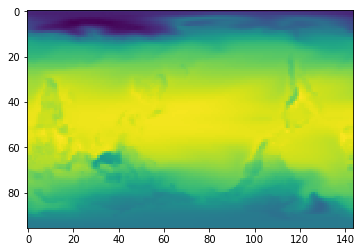

In [56]:
plot_data = all_data['ctl','tas','mean']

# this command generates the image but... 
plt.imshow(plot_data)
# ...it won't display until we tell the PLT module to show it.
plt.show()

The data is there but it's plotting upside down (The cold Antarctic is on top and Greenland is bottom right). We can do better.

Basemap produces much better map plots but requires more setting up.

In [74]:
"""
This function will setup basemap to produce a decent map of whatever variable we want. 
It will return a map object onto which we can plot things, and x,y coordinates for our data.
"""

def map_setup(lons, lats):

    # basemap needs 2D coordinate arrays
    lons2, lats2 = np.meshgrid(lons,lats)

    # We'll use a cylindrical projection
    m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
                    llcrnrlon=0,urcrnrlon=360,resolution='c')

    fig = plt.figure(figsize=(9,4))
    m.drawmapboundary(fill_color='white')

    # we'll draw coastlines onto our map
    m.drawcoastlines()

    # We'll also draw parallels and meridians
    m.drawparallels(np.arange(-90,120,30),labels=[1,0,0,0])
    m.drawmeridians(np.arange(m.lonmin,m.lonmax+30,60),labels=[0,0,0,1])

    x, y = m(lons2, lats2)

    return m, x, y

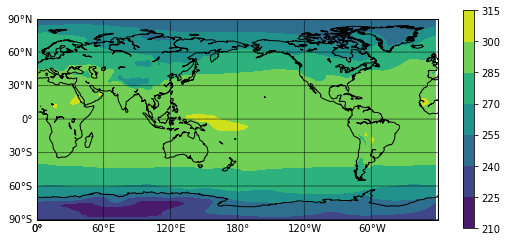

In [73]:
# let's plot the control surface air temperature again.
plot_data = all_data['ctl','tas','mean']

# Use map setup function to set up map. 
m, x, y = map_setup(lons, lats)

# Produce a contour plot using the plot_data
m.contourf(x,y,plot_data)

# Add a color bar.
plt.colorbar()

# Display the map
plt.show()

# Maps of the basic climate response to solar geoengineering

How well does solar geoengineering reverse the effects of climate change? Let's plot the surface air temperature and precipitation anomalies of CO2 - control and CO2&100%Geo - control.

# Different levels of geoengineering

We want to look at different levels of geoengineering.

In [37]:
def geo_fraction_data(fraction, var, stat):
    CO2_data = all_data['CO2',var,stat]
    Geo100_data = all_data['Geo100',var,stat]
    return CO2_data + fraction * (Geo100_data - CO2_data)

In [44]:
# Test to see that our function works
print geo_fraction_data(1.0, 'tas','mean') - all_data['Geo100','tas','mean']
print geo_fraction_data(0.0, 'tas','mean') - all_data['CO2','tas','mean']

[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]
[[[ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]]
